In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import getdata as gd

In [2]:
import strategy.trendlabeling as tlb

In [3]:
import getdata as gd
import afml.filters.filters as flt 
import afml.labeling.triplebarrier as tbar
import afml.util.volatility as vol
import features.bars as bars  

In [4]:
import matplotlib.pyplot as plt

## Import Dataset

In [5]:
df_yf = gd.get_yf_data(tickers= "SPY AAPL ALGM DNOW META", 
                    period='1y',   
                    interval='1d')

[*********************100%***********************]  5 of 5 completed


In [6]:
df = df_yf[df_yf['Ticker'] == 'ALGM']

## Get Labels using Trend Scanning method

In [7]:
# convert Adj Close to numpy
time_series = df['Adj Close'].to_numpy()
window_size_max= 7

# get trend scanning labels
label_output = tlb.get_trend_scanning_labels(time_series=time_series, 
                                             window_size_max=window_size_max, 
                                             threshold=0.0,
                                             opp_sign_ct=3,
                                             side='up')

# drop last rolling window size -1 rows
n = window_size_max-1
#df.drop(df.tail(n).index, inplace = True)
df = df.iloc[:-n]

# append the slope and labels to the df
df['slope'] = label_output['slope']
df['label'] = label_output['label']
# df['isEvent'] = label_output['isEvent']
# isEvent = df[df['isEvent']==1].index

## Form Dollar Bars

In [8]:
# construct the input data
_df = df.reset_index()
trades = _df[['Date', 'Adj Close', 'Volume']].to_numpy()

# define the dollar value to sample the data
frequency = _df.Volume.mean()*20

# generate the dollar bars
dollar_bars = bars.generate_dollarbars(trades, frequency=frequency) 

# define closing price
close = dollar_bars.close.copy()

In [9]:
# get Daily Volatility
dailyVolatility = vol.getDailyVol(close, span=50)

In [10]:
# apply cusum filter to identify events as cumulative log return passed threshold
tEvents = flt.getTEvents(close, h=dailyVolatility.mean())

## Create Trade or Not Trade labels using Triple Barrier Method

In [18]:
# Define vertical barrier - subjective judgment
num_days = 10

t1 = tbar.add_vertical_barrier(tEvents, close, num_days=num_days)

In [19]:
# get side labels from trend following method
side_labels = []

for dt in dollar_bars.index:
    side_labels.append(df.loc[dt]['label'])

side_labels = pd.Series(side_labels, index=dollar_bars.index)

In [24]:
# Define upper and lower horizontal barriers
# set profit and stop loss ratio
ptsl = [2,1]

# select minRet
minRet = 0.01 # requires at least 1 percent return

# Run in single-threaded mode on Windows
import platform, os
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = os.cpu_count() - 1
    
events = tbar.get_events(dollar_bars.close, 
                         t_events=tEvents[1:], 
                         pt_sl=ptsl, 
                         target=dailyVolatility, 
                         min_ret=minRet, 
                         num_threads=cpus, 
                         vertical_barrier_times=t1,
                         side_prediction=side_labels).dropna()

labels = tbar.get_bins(triple_barrier_events = events, close=close)

print(labels.bin.value_counts())

0    90
1    50
Name: bin, dtype: int64


c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\labeling\triplebarrier.py:50: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for loc, vertical_barrier in events_['t1'].fillna(close.index[-1]).iteritems():
c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\util\multiprocess.py:118: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)


In [25]:
# Drop underpopulated labels
clean_labels  = tbar.drop_labels(labels)

print(clean_labels.bin.value_counts())

0    90
1    50
Name: bin, dtype: int64


In [42]:
clean_labels

,ret,trgt,bin,side
2022-03-22,-0.031992,0.060906,0,1.0
2022-03-23,-0.006005,0.058208,0,1.0
2022-03-25,-0.035641,0.048972,0,1.0
2022-03-29,0.132253,0.042852,1,-1.0
2022-03-31,0.117670,0.048208,1,-1.0
...,...,...,...,...
2023-02-14,-0.031369,0.044063,0,1.0
2023-02-15,0.069648,0.043595,0,-1.0
2023-02-16,0.048917,0.042808,0,-1.0
2023-02-17,0.036571,0.043210,0,-1.0


#### Use features: volatility, serial correlation

In [44]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

def df_rolling_autocorr(df, window, lag=1):
    """Compute rolling column-wise autocorrelation for a DataFrame."""

    return (df.rolling(window=window)
            .corr(df.shift(lag)))

In [45]:
#serial correlation
srl_corr = df_rolling_autocorr(returns(close), window=7).rename('srl_corr')

In [46]:
features = (pd.DataFrame()
            .assign(vol=events.trgt)
            .assign(side=clean_labels.side)
            .assign(srl_corr=srl_corr)
            .drop_duplicates()
            .dropna())

In [47]:
Xy = (pd.merge_asof(features, clean_labels.bin, 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())

In [49]:
Xy.bin.value_counts()

0    87
1    47
Name: bin, dtype: int64

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

In [50]:
RANDOM_STATE = 42

X = Xy.drop('bin',axis=1).values
y = Xy['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

              precision    recall  f1-score   support

           0       0.74      0.87      0.80        46
           1       0.54      0.33      0.41        21

    accuracy                           0.70        67
   macro avg       0.64      0.60      0.61        67
weighted avg       0.68      0.70      0.68        67



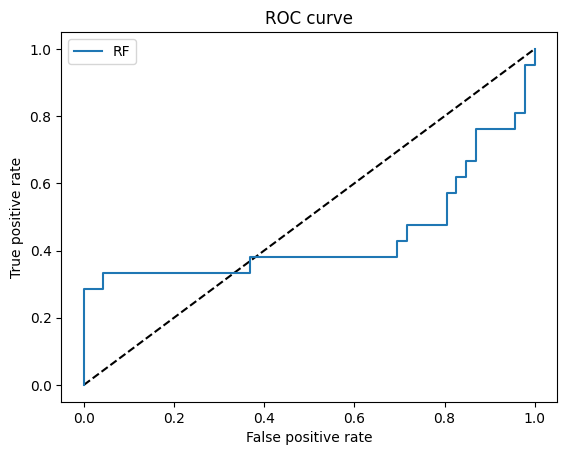

In [57]:
n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', 
                            #class_weight='balanced_subsample',
                            random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()